In [65]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import h5py

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, minmax_scale, robust_scale

import scipy.ndimage
from scipy import interpolate

In [2]:
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [3]:

with h5py.File('/mnt/c/Users/conor/Google Drive/PhD/Core4_Upsample.mat', 'r') as f:
    print(f.keys())

    core = 1-np.array(f['Core4_Area1'])
    ir = np.array(f['IR_Area1'])
    wns = np.array(f['wn1'])

<KeysViewHDF5 ['Core4_Area1', 'IR_Area1', 'wn1']>


In [119]:
with h5py.File('/mnt/c/Users/conor/Google Drive/PhD/G9_Area1.mat', 'r') as f:
    print(f.keys())

    core2 = 1-np.array(f['I_G9_AREA3'])
    ir2 = np.array(f['G9_IR_Area1'])
    wns2 = np.array(f['wn2'])

<KeysViewHDF5 ['G9_IR_Area1', 'I_G9_AREA3', 'wn2']>


In [4]:
scaler = RobustScaler()

x_train, x_test = train_test_split(scaler.fit_transform(ir.T.reshape(-1, wns.shape[1])))
#x_train, x_test = train_test_split(ir.T.reshape(-1, wns.shape[1]))

In [38]:
latent_dim = 32

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Input(x_train.shape[1]),
      layers.Flatten(),
      layers.Dense(256, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='relu'),
      layers.Dense(512, activation='relu'),
      layers.Dense(x_train.shape[1])
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [39]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [40]:
history = autoencoder.fit(x_train, x_train,
                epochs=5,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/5
7161/7161 [==============================] - 32s 4ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 2/5
7161/7161 [==============================] - 42s 6ms/step - loss: 8.6167e-04 - val_loss: 6.6233e-04
Epoch 3/5
7161/7161 [==============================] - 33s 5ms/step - loss: 6.0802e-04 - val_loss: 4.3660e-04
Epoch 4/5
7161/7161 [==============================] - 38s 5ms/step - loss: 4.8527e-04 - val_loss: 9.1400e-04
Epoch 5/5
7161/7161 [==============================] - 35s 5ms/step - loss: 4.0114e-04 - val_loss: 5.0190e-04


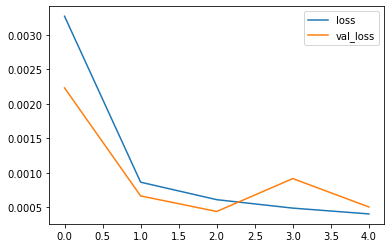

In [41]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

In [43]:
encoded = autoencoder.encoder(scaler.transform(ir.T.reshape(-1, wns.shape[1]))).numpy()
#encoded = autoencoder.encoder(ir.T.reshape(-1, wns.shape[1])).numpy()

mx = np.argmax(encoded.mean(axis=0))

core_scaled = minmax_scale(core.T.reshape(-1,1), feature_range=(np.quantile(encoded[:,mx],.01), np.quantile(encoded[:,mx],.99)))
#core_scaled = minmax_scale(core.T.reshape(-1,1), feature_range=(encoded[:,].min(), encoded[:,0].max()))

#stacked = np.concatenate([core_scaled.T.reshape(-1,1), encoded[:,1:]], axis=1)
stacked = encoded.copy()
stacked[:,mx] = core_scaled.squeeze()
#stacked = encoded

mapped = autoencoder.decoder(stacked).numpy()
up_scaled = mapped.reshape(ir.T.shape)

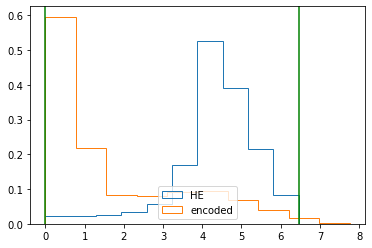

In [44]:
plt.hist(core_scaled, label='HE', histtype='step', density=True)
plt.hist(encoded[:,mx].flatten(), label='encoded', histtype='step', density=True)
plt.axvline(np.quantile(encoded[:,mx],.01), c='g')
plt.axvline(np.quantile(encoded[:,mx],.99), c='g')
plt.legend()

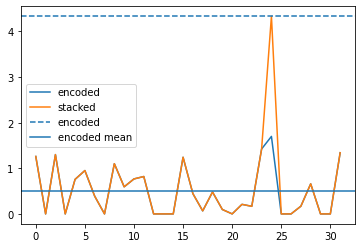

In [46]:
plt.plot(encoded.mean(axis=0), label='encoded')
plt.plot(stacked.mean(axis=0), label='stacked')
plt.axhline(core_scaled.mean(axis=0), label='encoded', ls='--')
plt.axhline(encoded.mean(), label='encoded mean')
plt.legend()

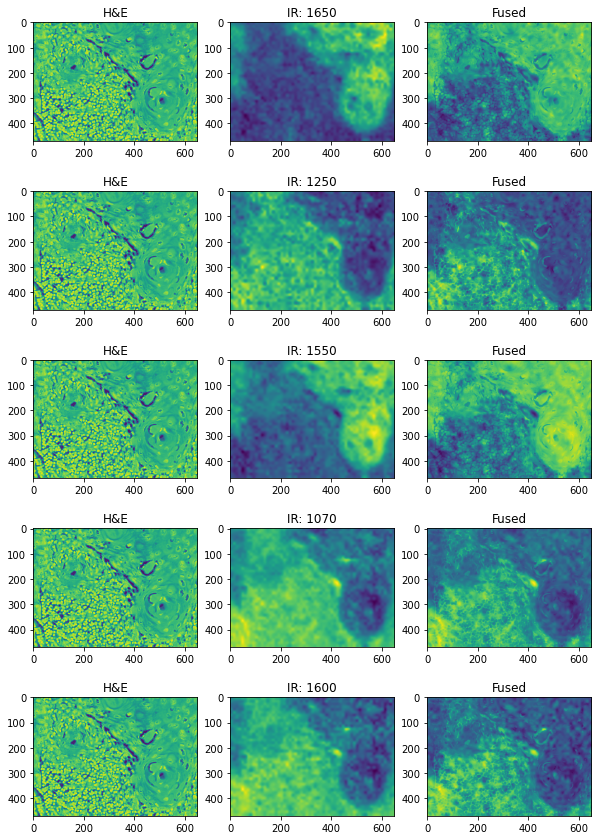

In [48]:
wns_ = [1650, 1250, 1550, 1070, 1600]

fig, rows = plt.subplots(figsize=(10, 3*len(wns_)), ncols = 3, nrows = len(wns_))

for wn, cols in zip(wns_, rows):

    wni = np.argmin([np.abs(wn - i) for i in wns.squeeze()])

    for title, col, im in zip(['H&E',f'IR: {wn}','Fused'], cols, [core.T, ir[wni,:,:].T, up_scaled[:,:,wni]]):

        col.set_title(title)
        col.imshow(im)

fig.savefig('./Fusion_Results.pdf')

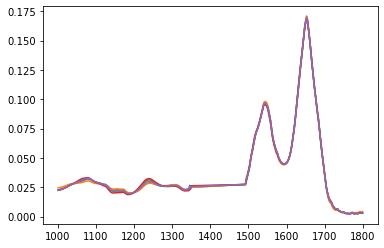

In [49]:
for i in np.random.randint(0,7000,5):
    
    plt.plot(wns.squeeze(), scaler.inverse_transform(mapped)[i, :].T)

In [120]:
def interp_wn(old_tab, old_wn, new_wn):

    new_tab = np.zeros((old_tab.shape[0], new_wn.shape[1]))

    for i in range(old_tab.shape[0]):

        new_tab[i,:] = interpolate.interp1d(old_wn.squeeze(),old_tab[i,:], bounds_error=False)(new_wn.squeeze())

    return new_tab

In [150]:
wns.shape

(1, 343)

In [149]:
new_tab.shape

(345488, 343)

In [139]:
new_tab = interp_wn(np.einsum('ijk->jki', ir2).reshape(-1, wns2.shape[1]), wns2, wns)

ir2n = new_tab.reshape((-1,)+ir2.shape[:-1])

ValueError: cannot reshape array of size 118502384 into shape (174,604)

In [145]:
wns2.shape

(1, 174)

In [147]:
ir2.shape[1:]

(604, 572)

In [140]:
ir2.shape

(174, 604, 572)

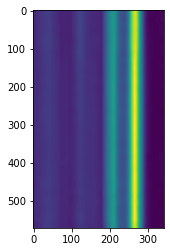

In [141]:
plt.imshow(new_tab.reshape(ir2.shape[1:] + (-1,))[140,:,:])

In [129]:
encoded = autoencoder.encoder(scaler.transform(ir2n.T.reshape(-1, wns.shape[1]))).numpy()
#encoded = autoencoder.encoder(ir.T.reshape(-1, wns.shape[1])).numpy()

mx = np.argmax(encoded.mean(axis=0))

core_scaled = minmax_scale(core2.T.reshape(-1,1), feature_range=(np.quantile(encoded[:,mx],.01), np.quantile(encoded[:,mx],.99)))
#core_scaled = minmax_scale(core.T.reshape(-1,1), feature_range=(encoded[:,].min(), encoded[:,0].max()))

#stacked = np.concatenate([core_scaled.T.reshape(-1,1), encoded[:,1:]], axis=1)
stacked = encoded.copy()
stacked[:,mx] = core_scaled.squeeze()
#stacked = encoded

mapped = autoencoder.decoder(stacked).numpy()
up_scaled = mapped.reshape(ir2n.T.shape)

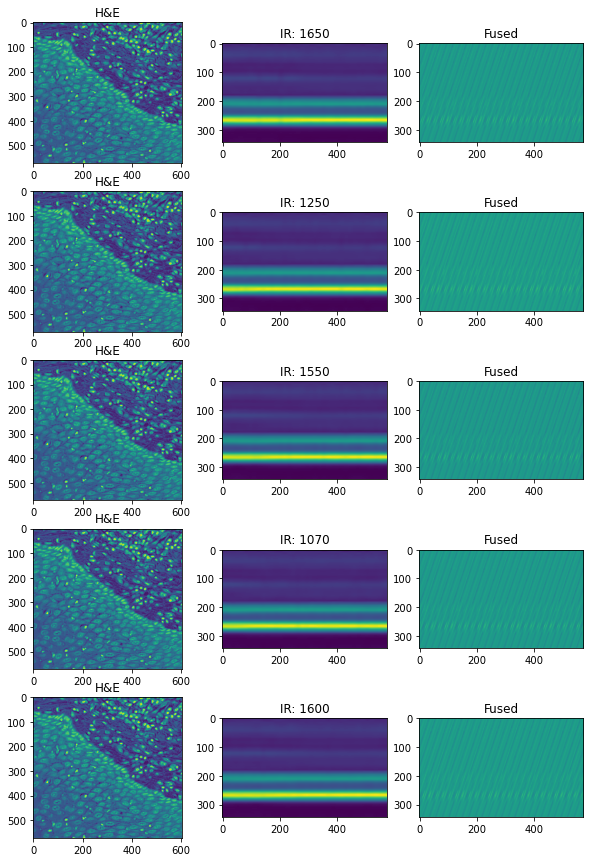

In [130]:
wns_ = [1650, 1250, 1550, 1070, 1600]

fig, rows = plt.subplots(figsize=(10, 3*len(wns_)), ncols = 3, nrows = len(wns_))

for wn, cols in zip(wns_, rows):

    wni = np.argmin([np.abs(wn - i) for i in wns.squeeze()])

    for title, col, im in zip(['H&E',f'IR: {wn}','Fused'], cols, [core2.T, ir2n[wni,:,:].T, up_scaled[:,:,wni]]):

        col.set_title(title)
        col.imshow(im)

fig.savefig('./Fusion_Results.pdf')